# Planification de la trajectoire d'un objet mobile à partir des images video
## BRIKCI Mohammed El Hadi et BRAHIM Riadh
### Université des Sciences et de la Technologie d'Oran MOHAMED BOUDIAF 

Dans ce code on a une solution pour detection les marquage des lignes de la voie . En suivant les etapes suivante:

1. Calibration de la Camera   
2. Correction de Distortion    
3. Seuillage de Gradient (Canny) et Seuillage de couleur 
4. Transformation de Perspective    
5. La recherche des lignes de la voie (Sliding windows) & Optimization de la recherche (merging search)
6. Dessiner de la superposition de voie
7. Calcule le rayon de la courbure et le décalage de la voiture

##### Les Bibliothèques requises

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import io
import os
import glob
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Calculer l'étalonnage de la caméra à l'aide d'images d'échiquier

In [2]:
images = glob.glob('camera_cal/calibration*.jpg') #glob pour charger +ieurs images

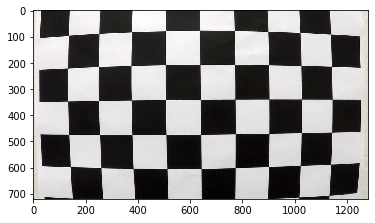

In [3]:
img = mpimg.imread(images[0]) #Liire la 1er image
plt.imshow(img);

In [4]:
# stocker les coordonnées de l'échiquier 
chess_points = []
# stocker les points img transformés
image_points = []

In [5]:
# Spécifier le nombre de Lignes et columnes a 6, 9. chaque élément est en (xyz) point 
# Rappel, on s'interesse que des points intérieurs. c'est pour sa la plache d'échiquier est de 9x6, au lieu 10x7
chess_point = np.zeros((9*6, 3), np.float32)
# z reste zero. définir xy au valeurs de la grille
chess_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [6]:
for image in images:
    # Lire les images d'echiquier
    img = mpimg.imread(image) 
    # convertir au niveau de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # returner booléen s/e et les coordonnes
    success, corners = cv.findChessboardCorners(gray, (9,6), None)
    
    if success:
        image_points.append(corners)
        # Ils seront tous les mêmes puisque c'est la même planche
        chess_points.append(chess_point)
    else:
        print('corners not found {}'.format(image))
        

corners not found camera_cal\calibration1.jpg
corners not found camera_cal\calibration4.jpg
corners not found camera_cal\calibration5.jpg


<Figure size 432x288 with 0 Axes>

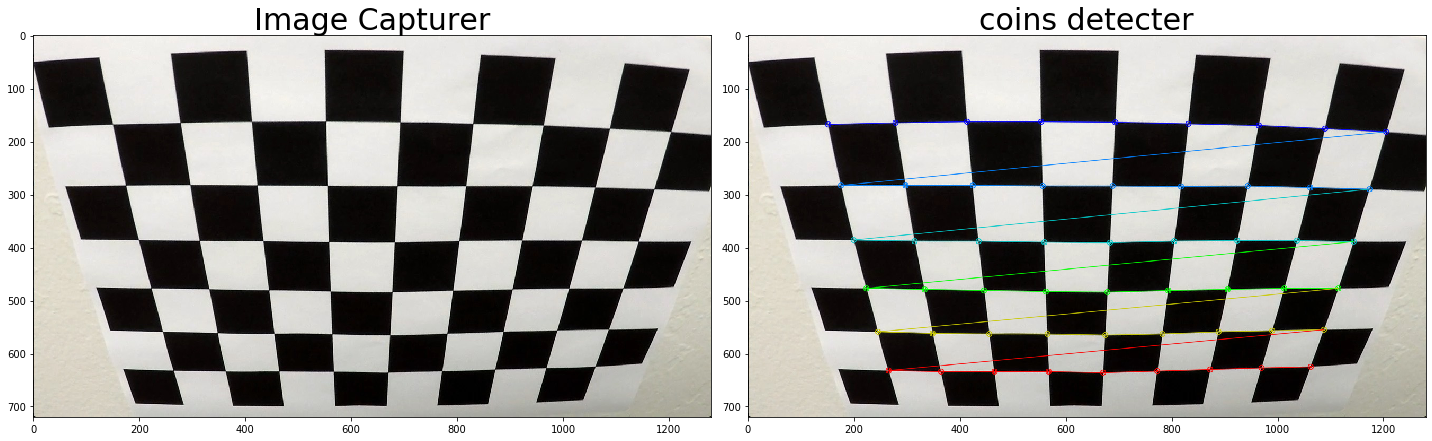

In [7]:
# Puisque les images 1,4,5 ne sont pas chargé ont va lire la 2eme
image = mpimg.imread('./camera_cal/calibration2.jpg')
# affichage des résultats 
plt.figure();
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(image);
ax1.set_title('Image Capturer', fontsize=30);

gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY) 
ret , corners = cv.findChessboardCorners(gray,(9,6),None)    
if ret == False:
    print('coins non detecter')
img1 = cv.drawChessboardCorners(image,(9,6),corners,ret) 

ax2.imshow(img1);
ax2.set_title('coins detecter', fontsize=30);
plt.tight_layout();
plt.savefig('saved_figures/chess_corners.png'); # vous devez creer un dossier pour sauvgarder les figures
plt.show;

In [8]:
# Sauvegarder les donnees dans un fichier Pickle! et je l'ai mis en comentaire pcq c'est pas la peine de sauvegarder a chaque fois
# une seule fois suffit 

# points_pkl = {}
# points_pkl["chesspoints"] = chess_points
# points_pkl["imagepoints"] = image_points
# points_pkl["imagesize"] = (img.shape[1], img.shape[0])
# pickle.dump(points_pkl,open("object_and_image_points.pkl", "wb" ))

In [9]:
points_pickle = pickle.load( open( "object_and_image_points.pkl", "rb" ) ) 
chess_points = points_pickle["chesspoints"]
image_points = points_pickle["imagepoints"]
img_size = points_pickle["imagesize"]

In [10]:
# Application de la fonction calibrate 
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(chess_points, image_points, img_size, None, None)

In [11]:
# enregistrer dans un fichier pickle!
# camera = {}
# camera["mtx"] = mtx
# camera["dist"] = dist
# camera["imagesize"] = img_size
# pickle.dump(camera, open("camera_matrix.pkl", "wb"))

In [12]:
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    #print(img_size1)
    #print(camera_img_size)
    assert (img_size1 == camera_img_size),'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx) # Application de la fonction undistort pour la correction d'image
    return undist

<Figure size 432x288 with 0 Axes>

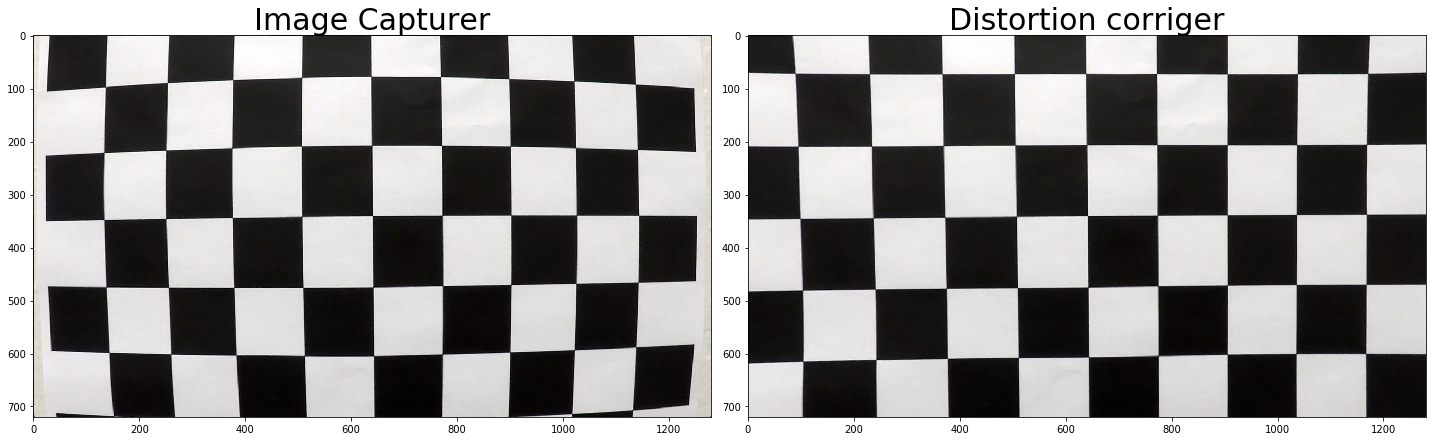

In [13]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size1 = (img.shape[1], img.shape[0])

undist = distort_correct(img, mtx, dist, img_size)

### Visualisation des résultats 
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Image Capturer', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Distortion corriger', fontsize=30);
plt.tight_layout()
plt.savefig('saved_figures/undistorted_chess.png')

### seillage de gradient et couleur

Pour ce projet, nous utiliserons plusieurs filtres pour générer une image binaire (noir et blanc) pour que nous pouvons détecter  les lignes de voie.

* Sobel gradients en x & y directions
* Gradient magnitude
* Gradient direction
* Transformation et filtrage de l'espace colorimétrique

In [14]:
########################################################""
# charger camera matrix et coefficient de distortion
camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']

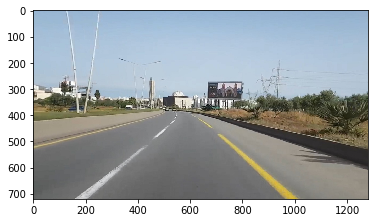

In [15]:
# obtenir un cadre undistorted dashcam 
image = mpimg.imread('test_images/barki.jpg')  # c'est une image prise d'oran (barki) source: (Chaine YouTube: Malik dz)
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

#### Sobel gradients
Canny Edge Detection (detecteur de contour) combine le gradient sobel pour x et y. En le décomposant en ses composants, 
on peut produire une version raffinée de la détection des contours Canny.

In [16]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # 1) Convertir en niveau de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Appliquer x ou y gradient avec la fonction OpenCV Sobel() 
    # et prendre la valeur absolue
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    # 3) Reduire en entier de 8 bit 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Creer une copie et appliquer le suillage
    binary_output = np.zeros_like(scaled_sobel)
    # 5) Ici j'utilise un seuillage inclusive (>=, <=), mais on peut utilisé exclusive aussi
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Returner le resultat
    return binary_output

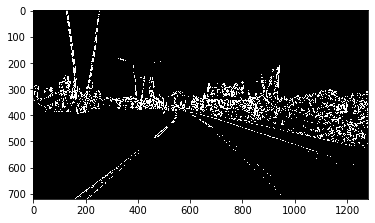

In [17]:
# Modifier la couleur de map en gris, RGB par defaut
plt.imshow(abs_sobel_thresh(image, thresh=(20,110)),  cmap='gray'); # seuillage 20,110
# Vous pouvez utilisez d'autres seuillage pour detection plus precise

#### Gradient Magnitude
La fonction ci-dessous filtrera en fonction d'une magnitude min / max pour le gradient. Cette fonction examine le gradient xy combiné, mais il pourrait être modifié pour filtrer la magnitude dans une seule direction, ou une combinaison linéaire des deux pour retourné l'intensité des contour en appliquant la norme √x²+y² (sobelx et sobely).

In [18]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convertir en niveaux de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Prendre le gradient en x and y separament
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculer xy magnitude 
    mag = np.sqrt(x**2 + y**2)
    # 4) Reduire en entier de 8 bit (0 - 255) et le convertir en type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Creer un masque binaire lors que le seuillage de mag est aborder.
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1 
    return binary_output

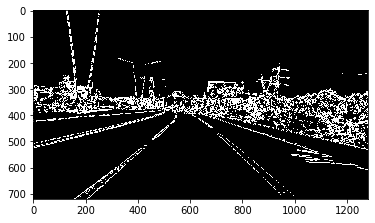

In [19]:
plt.imshow(mag_threshold(image, thresh=(20,100)),  cmap='gray'); 
# La meme chose ici Vous pouvez utilisez d'autres seuillage

#### Gradient Direction
Cette fonction filtrera en fonction de la direction du gradient. Pour la détection de voie, on va orientér la detection c'est a dire on sera intéressés par les lignes verticales qui sont +/- un certain seuil près $\frac{\pi}{2}$

In [20]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convertir en niveaux de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Prendre le gradient en x and y separament
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Uiliser np.arctan2(abs_sobely, abs_sobelx) pour calculer la direction du gradient 
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

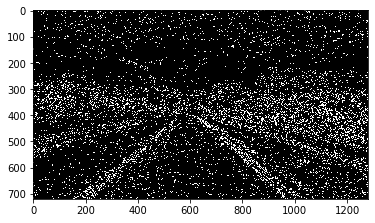

In [21]:
plt.imshow(dir_threshold(image, thresh=(0.8,1.2)),  cmap='gray');
# La meme chose ici Vous pouvez utilisez d'autres seuillage

#### Saturation Channel & Red Channel Filters
Les filtres de Gradient convertissent avant tout l'image d'origine en niveaux de gris et beaucoup d'informations utiles sont perdues. Les lignes de voie sont jaunes ou blanches, et nous pouvons utiliser cela à notre avantage en essayant de les localiser et de les suivre. The **H**ue **S**aturation **L**ightness (teinte,saturation,légèreté) coleur de espace va nous aider. en particulier, le canal S of an HSL l'image conserve beaucoup d'informations sur les lignes de voie - surtout quand il y a des ombres sur la route. canal rouge de RGB lui aussi fait un bon travaille pour la creation d'image binaire de detection de voie

In [22]:
def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convertir en HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Application un seuillage au canal S et L de hsl
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Returner une image binaire de seuillage resultat
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

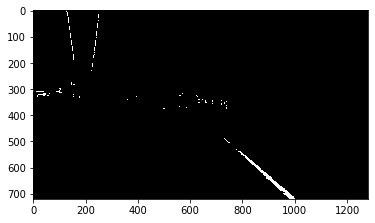

In [23]:
plt.imshow(hls_select(image, sthresh=(140,255), lthresh=(120, 255)),  cmap='gray');
# La meme chose ici Vous pouvez utilisez d'autres seuillage mais comme vous voyez il y a seux seuillage pour le canal L et S

In [24]:
def red_select(img, thresh=(0, 255)):
    # Application un seuillage au canal R du RGB
    R = img[:,:,0]
    # Returner une image binaire du seuillage resultat
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

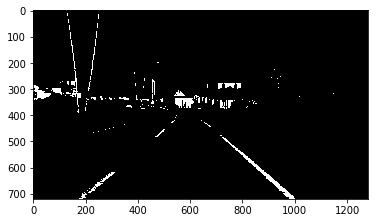

In [25]:
plt.imshow(red_select(image, thresh=(200,255)),  cmap='gray');
# La meme chose ici Vous pouvez utilisez d'autres seuillage

### Methodes pour combiner les filtres
Nous pouvons maintenant mélanger et assortir différentes méthodes de filtrage, chacun avec des valeurs de seuillage uniques, pour obtenir une image binaire raffinée.

In [26]:
def binary_pipeline(img):
    
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    #img_copy = np.copy(img)
    
    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    red_binary = red_select(img_copy, thresh=(200,255))
    
    # Sobel x
    x_binary = abs_sobel_thresh(img_copy,thresh=(25, 200))
    y_binary = abs_sobel_thresh(img_copy,thresh=(25, 200), orient='y')
    xy = cv.bitwise_and(x_binary, y_binary)
    
    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    
    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    s_r = cv.bitwise_or(s_binary, red_binary)
    final_binary = cv.bitwise_or(s_r, gradient)
    
    return final_binary

<Figure size 432x288 with 0 Axes>

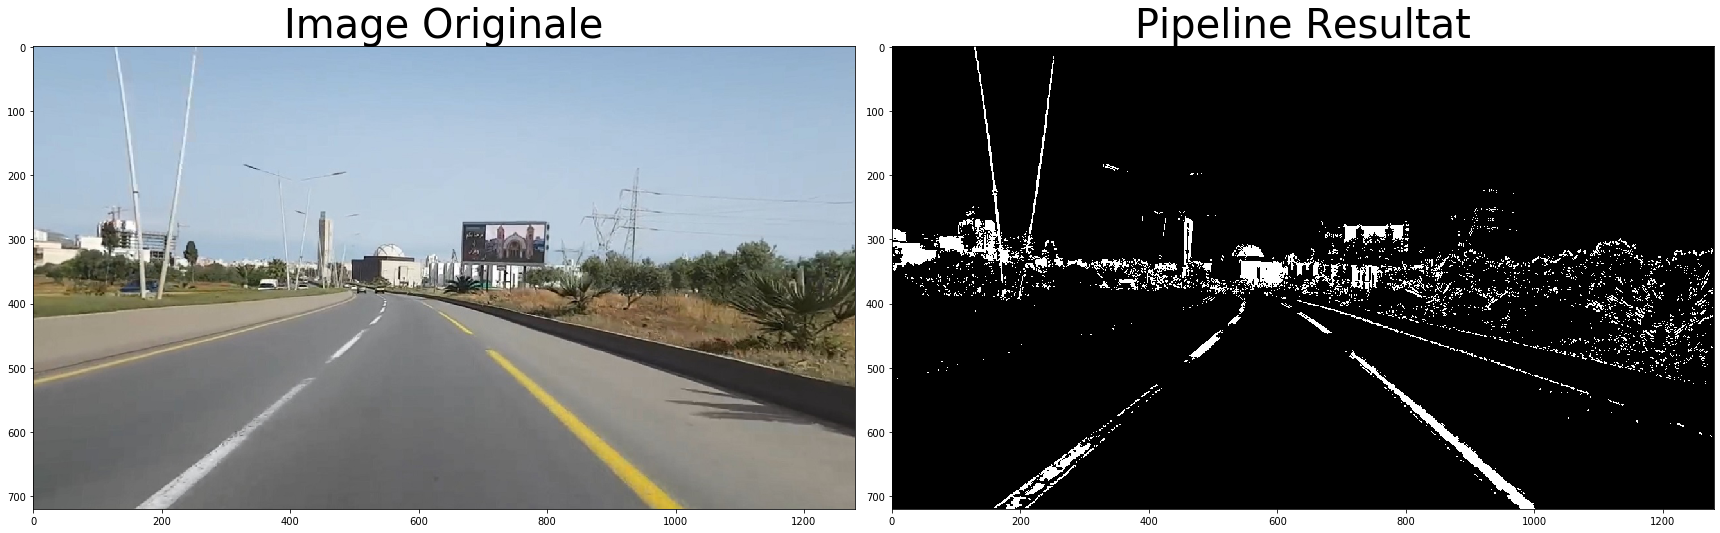

In [27]:
result = binary_pipeline(image)

# Afficher le resultat
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Image Originale', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Resultat', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/combined_filters.png')

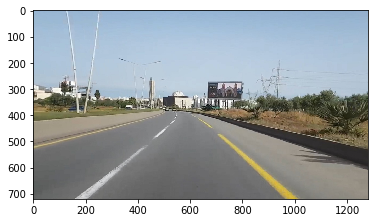

In [28]:
# Maintenant on va corriger l'image 
image = mpimg.imread('test_images/barki.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

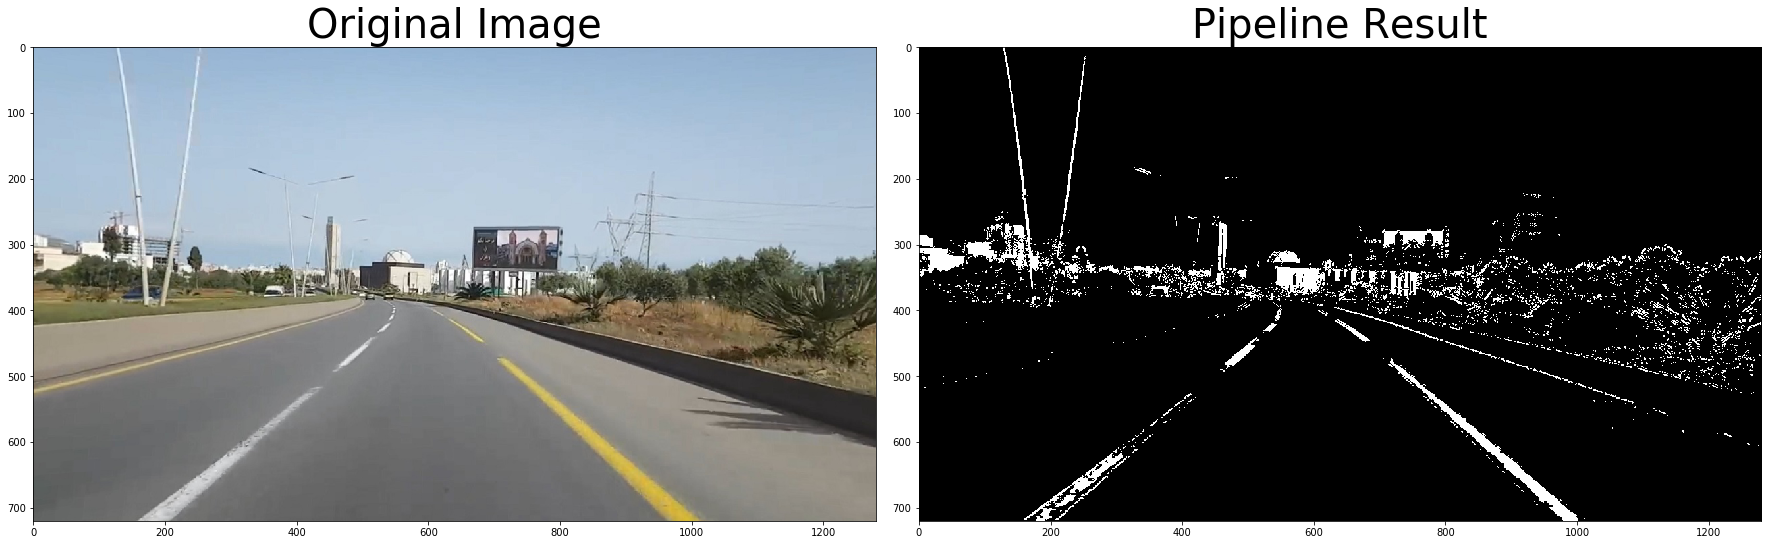

In [29]:
# Maintenant on va appliquer les seuillage de gradient et coouleur sur l'image corriger
result = binary_pipeline(image)

# afficher le resultat
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective transform
On travaille avec Perspective transform pour avoir " Bird eye view " c'est a dire vu du ciel, pourquoi, pour faciliter la detection les marquages des lignes de la voie et les suivre. 

In [30]:
def warp_image(img):
    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    # L'ordre des points dans le polygone que vous définissez n'a pas d'importance
    # Mais elles doivent bien correspondre aux points correspondants dans destination_points!
    source_points = np.float32([
    [0.117 * x, y],                   # 149.76, 720
    [(0.5 * x) - (x*0.13), (2/3)*y],  # 166.4 , 480
    [(0.5 * x) + (x*0.078), (2/3)*y], # 739.84 , 480
    [x - (0.117 * x), y]              # 84.24 , 720
    ])


    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    # Creer la matrice de transformation
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points) 
    # Creer la matrice pour anuller la transformation
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    # Application de transformer de perspective
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    #print(source_points)
    #print(destination_points)
    
    return warped_img, inverse_perspective_transform

<Figure size 432x288 with 0 Axes>

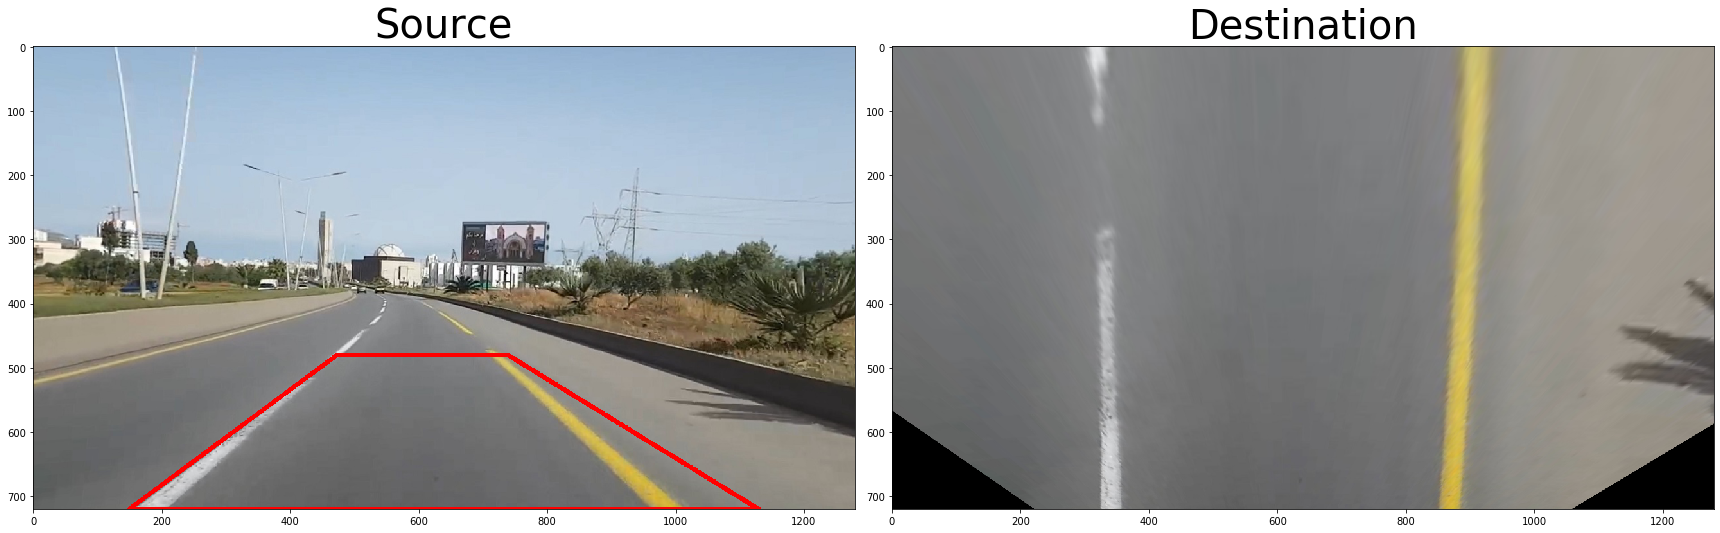

In [31]:
birdseye_result, inverse_perspective_transform = warp_image(image)  # image  #result

# Afficher le resultat
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]

source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.13), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

# Tracer le polygone des points sources
draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transform.png')

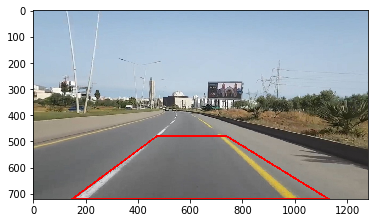

In [32]:
# C'est juste pour avoir l'image source dessiner
plt.imshow(draw_poly)

<Figure size 432x288 with 0 Axes>

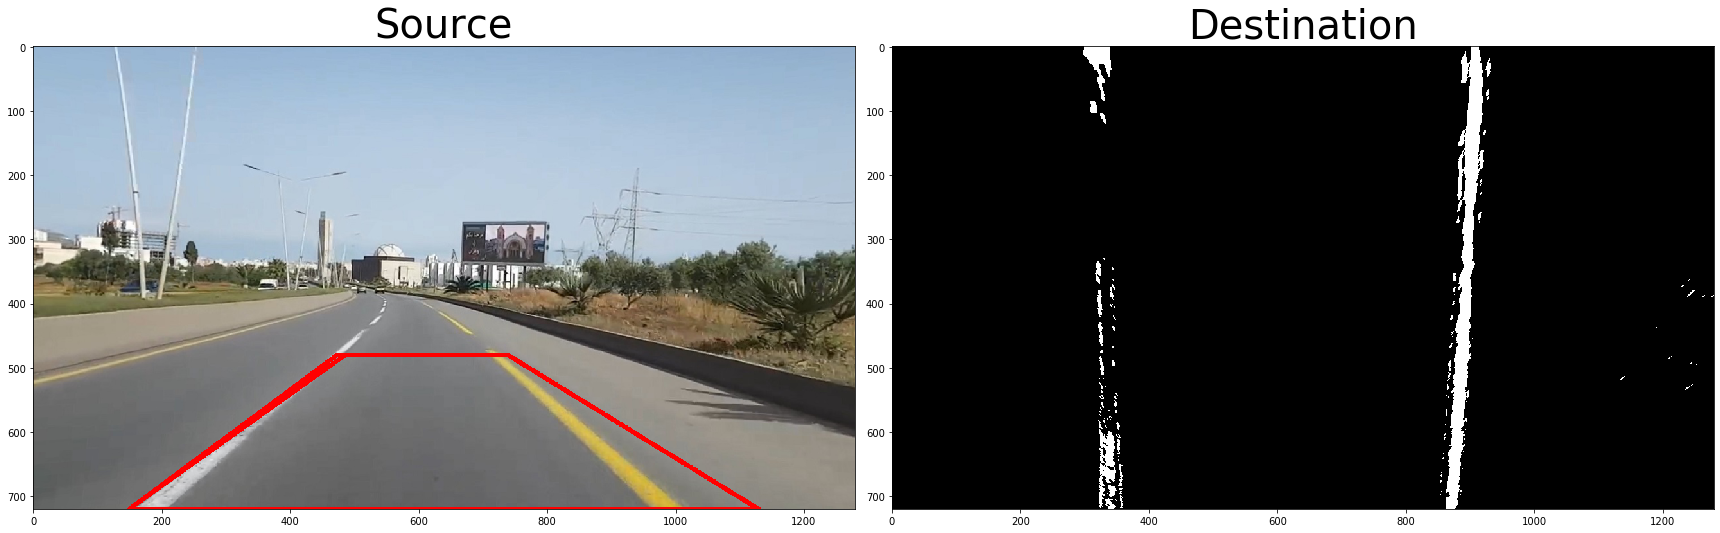

In [33]:
# Dans cette partie on va applique les deux traitement les seuillage de gradient et couleur 
# et la transormation de perspective

birdseye_result, inverse_perspective_transform = warp_image(result)  

# Afficher le resultat
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.12), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

# Tracer le polygone des points sources
draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transformb.png')

In [34]:
# Recharger l'image l'utilisé plus tard
image = mpimg.imread('test_images/barki.jpg')
# Coriiger l'image 
image = distort_correct(image,mtx,dist,camera_img_size)

### Détection les lignes du marquage de la voie

Maintenant que notre capture de la route a été transformé, nous sommes prêts de trouver et de suivre les marquages des voies réelles. Pour le faire, nous pouvons identifier les zones avec un nombre élevé de pixels blancs. Plus précisément, nous utiliserons un histogramme pour regrouper les pixels en colonnes et rechercher des pics les plus grand dans la distribution.

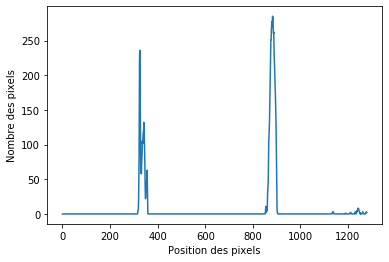

In [35]:
# On s'interesse seulement a la moitié inférieure d'image
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure();
plt.plot(histogram);
plt.xlabel('Position des pixels')
plt.ylabel('Nombre des pixels')
plt.savefig('saved_figures/lane_histogram.png')

Tous d'abord on fait un histogramme qui calcule la somme des pixels blanc, Comme vous voyez on a deux pics et ses deux pics identifient les debuts des lignes (gauche et droite)

Nous pouvons clairement voir où se trouvent les debuts des lignes de les voies dans cet histogramme. En mettant en place des fenêtres coulissantes, Nous pouvons suivre les pics lorsqu'ils virent à gauche / droite en raison de la légère courbure de la route.

La fonction ci-dessous fonctionne comme suit:
1. Créez une fenêtre de recherche en bas de l'image dont la hauteur est $\frac{1}{9}$ de la hauteur de l'image. 
2. Divisez la fenêtre en deux parties gauche et droite.
3. Localisez la colonne de pixels avec la valeur la plus élevée dans l'histogramme.
4. Tracez un cadre autour de cette zone à l'aide d'une variable de marge. 
5. Identifiez tous les pixels non nuls de cette zone. S'il y en a assez, centrez la boîte sur leur position moyenne pour la fenêtre suivante.
6. Ajuster une équation quadradtique (Polynome 2eme degre) à tous les pixels non nuls identifiés dans chaque moitié de l'image (voie de gauche et voie de droite)

In [37]:
ym_per_pix = 30/720 # meters per pixel in y dimension, 8 lines (5 spaces, 3 lines) at 10 ft each = 3m
xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
def track_lanes_initialize(binary_warped):
    
    global window_search
    
    # x = img.shape[1]
    # y = img.shape[0]
    # Prendre la moitié inférieure de histogramme d'image
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Créez une image de sortie pour dessiner et visualiser le résultat
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # nous avons besoin de max de chaque moitié de l'histogramme. l'exemple ci-dessus montre comment
    # les choses pourraient être compliquées si elles ne divisaient pas l'image en deux
    # avant de prendre les 2 premiers maxs
    
    midpoint = np.int(histogram.shape[0]/2) # diviser l'histogramme en deux
    leftx_base = np.argmax(histogram[:midpoint])   # les indices de Max de la 1er moitie (le pic gauche)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint   # les indices de Max de la 2eme moitie (le pic droite)
    
    # Choisissez le nombre de fenêtres coulissantes
    # cela générera une erreur de hauteur si elle ne divise pas également la hauteur img
    nwindows = 9
    
    # Définir la hauteur des fenêtres
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identifier les positions x et y de tous les pixels non nuls de l'image (les pixels blanches)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Positions actuelles à mettre à jour pour chaque fenêtre
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Définir la largeur des fenêtres +/- marge
    margin = 100
    
    # Définir le nombre minimum des pixels trouvés dans la fenêtre la plus récente
    minpix = 50
    
    # Créez des listes vides pour recevoir les indices de pixels des voies gauche et droite
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Parcourez les fenêtres une par une
    for window in range(nwindows):
        # Identifier les limites des fenêtres en x et y (et à droite et à gauche)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Dessinez les fenêtres sur l'image de visualisation
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        
        # Identifiez les pixels non nuls en x et y dans la fenêtre
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Ajouter ces indices aux listes
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Si vous avez trouvé > pixels minpix, plus récente fenêtre suivante sur leur position moyenne
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concaténer les tableaux d'indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extraire les positions des pixels des lignes gauche et droite
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Adapter un polynôme de second ordre à chacun
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Générer des valeurs x et y pour le traçage
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Encore une fois, extraire les positions des pixels des lignes gauche et droite
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Adapter un polynôme de second ordre à chacun
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Adapter un polynôme de second ordre à chacun converti metre par pixel
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, left_fit_m, right_fit_m, out_img

In [38]:
img = mpimg.imread('test_images/barki.jpg')
img = distort_correct(img,mtx,dist,camera_img_size)     
# Exécuter le warp_image sur image binaire du pipeline
# Exécuter track_lanes_initialize sur birdseye
left_fit, right_fit, left_fit_m, right_fit_m, out_img = track_lanes_initialize(birdseye_result)

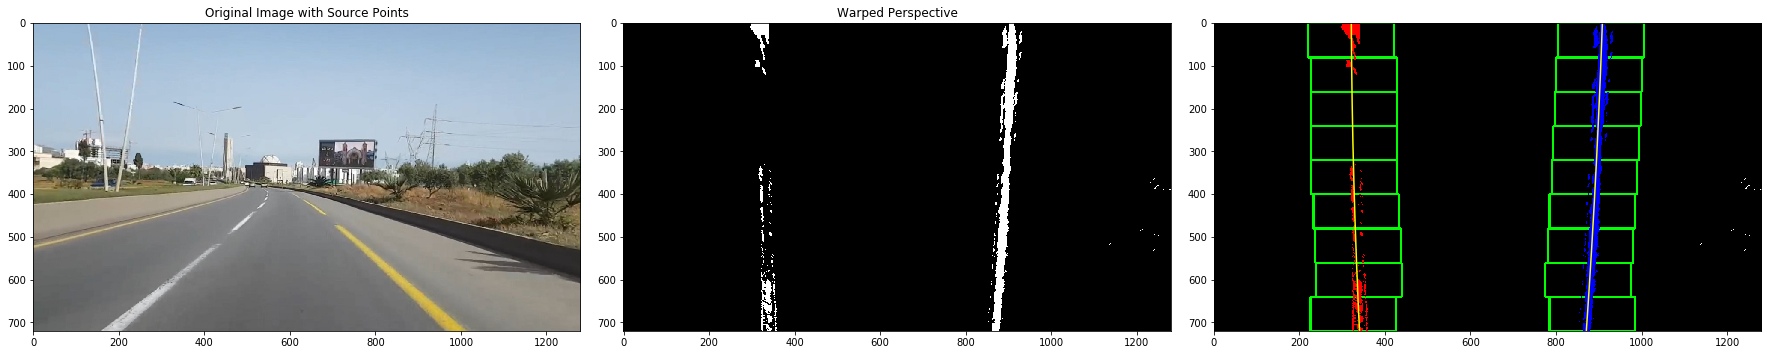

In [39]:
# Afficher l'image originale, l'image binaire transformer, et la visualisation des fenetres coulissante
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Image Original avec les Points Source')
    
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Transformer de Perspective')
    
    # Generate x and y values for plotting
ploty = np.linspace(0, birdseye_result.shape[0]-1, birdseye_result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
ax3.imshow(out_img)
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('saved_figures/Sliding_window_search.png')